In [1]:
# Import Libraries #
import findspark
# findspark.find()
findspark.init()
from pyspark.sql.functions import split, col, array_contains, translate, round, size, when, udf, lit, mean, count, format_number, collect_list, expr
from pyspark.sql.types import TimestampType, MapType, IntegerType, StringType, ArrayType, FloatType, StructField, StructType
from pyspark.sql import SparkSession
from helper import *

In [2]:
spark = SparkSession.builder.appName('test').master("yarn") \
.config("spark.executor.instances", 12) \
.config("spark.executor.memory", "1G")  \
.getOrCreate()

2023-04-26 21:37:41,676 INFO spark.SparkContext: Running Spark version 3.3.2
2023-04-26 21:37:42,130 INFO resource.ResourceUtils: ==============================================================
2023-04-26 21:37:42,132 INFO resource.ResourceUtils: No custom resources configured for spark.driver.
2023-04-26 21:37:42,132 INFO resource.ResourceUtils: ==============================================================
2023-04-26 21:37:42,133 INFO spark.SparkContext: Submitted application: test
2023-04-26 21:37:42,177 INFO resource.ResourceProfile: Default ResourceProfile created, executor resources: Map(cores -> name: cores, amount: 1, script: , vendor: , memory -> name: memory, amount: 1024, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Map(cpus -> name: cpus, amount: 1.0)
2023-04-26 21:37:42,209 INFO resource.ResourceProfile: Limiting resource is cpus at 1 tasks per executor
2023-04-26 21:37:42,217 INFO resource.ResourceProfileManager: Added Resou

In [3]:
## MUTE OUTPUT FROM SPARK
## Enable during development
logger = spark._jvm.org.apache.log4j
logger.LogManager.getLogger("org").setLevel(logger.Level.OFF)
logger.LogManager.getLogger("akka").setLevel(logger.Level.OFF)
spark.conf.set("spark.driver.log.level", "OFF")

In [4]:
spark

In [5]:
#Event, White, Black, Result, WhiteElo, BlackElo, Opening, TimeControl, Termination, Moves,Eval, UTCTimestamp
schema = StructType([ \
    StructField("Event",StringType(),True), \
    StructField("White",StringType(),True), \
    StructField("Black",StringType(),True), \
    StructField("Result", StringType(), True), \
    StructField("WhiteElo", IntegerType(), True), \
    StructField("BlackElo", IntegerType(), True), \
    StructField("Opening",StringType(),True), \
    StructField("TimeControl",StringType(),True), \
    StructField("Termination",StringType(),True), \
    StructField("Moves", StringType(), True), \
    StructField("Eval", StringType(), True), \
    StructField("UTCTimestamp", TimestampType(), True) \
  ])
df = spark.read.csv("hdfs://namenode:9000/chess_2016_dataset/output/part*", schema=schema).cache()

##### Check Shape of Data

In [6]:
print("shape: ", (df.count(), len(df.columns)))

shape:  (4871421, 12)


##### Convert columns to appropriate types

In [7]:
df = convert_types(df)
df.dtypes

[('Event', 'string'),
 ('White', 'string'),
 ('Black', 'string'),
 ('Result', 'string'),
 ('WhiteElo', 'int'),
 ('BlackElo', 'int'),
 ('Opening', 'string'),
 ('TimeControl', 'string'),
 ('Termination', 'string'),
 ('Moves', 'array<string>'),
 ('Eval', 'array<float>'),
 ('UTCTimestamp', 'timestamp')]

### Find Eval Games and add blunders column for black and white.

In [8]:
eval_difference = 3.0
eval_games = df.where(col("Eval")[0].isNotNull())
eval_games = eval_games.withColumn("WhiteBlunders", (find_white_blunders(col("Eval"), lit(eval_difference)))).cache()
eval_games = eval_games.withColumn("BlackBlunders", (find_black_blunders(col("Eval"), lit(eval_difference))))
eval_games.count()

656419

In [9]:
eval_games.select("TimeControl", "White", "WhiteElo", "WhiteBlunders", "Black", "BlackElo", "BlackBlunders", "Result", "Termination") \
    .orderBy(col("WhiteBlunders").desc(), col("BlackBlunders").desc()).limit(10).toPandas().head(10)

,TimeControl,White,WhiteElo,WhiteBlunders,Black,BlackElo,BlackBlunders,Result,Termination
0,300+0,phico,1500,24,lawler,1437,12,1-0,Time forfeit
1,180+0,suarez,935,23,tigresa1,816,11,0-1,Time forfeit
2,180+0,tigresa1,826,20,suarez,926,16,0-1,Time forfeit
3,180+0,GoldChainGrinderfan,2064,19,IKnowSomeChess,1508,21,1/2-1/2,Normal
4,300+5,dynamo21,1649,19,viviero,1705,14,1/2-1/2,Normal
5,180+0,awl57,1744,18,nader-rajaii999,1751,17,1/2-1/2,Normal
6,600+5,iknowyoursecret,1342,17,ricore2015,1283,17,1-0,Normal
7,30+0,broskall,2290,16,BitChess,2401,17,1-0,Time forfeit
8,180+0,finnaubrey,911,16,wocho8712,1203,14,1/2-1/2,Normal
9,2100+30,ustadburak,1365,16,Larsiwan,1363,13,1/2-1/2,Normal


In [10]:
df.select("TimeControl", "White", "WhiteElo", "Black", "BlackElo", "Result", "Termination") \
    .orderBy(col("White").desc()).limit(10).toPandas().head(10)

,TimeControl,White,WhiteElo,Black,BlackElo,Result,Termination
0,300+0,zzzzzxzzzzz,2065,santiago8479,1427,1-0,Normal
1,300+0,zzzzzxzzzzz,2059,kerin84,2097,0-1,Normal
2,300+0,zzzzzxzzzzz,2057,salvini,2058,1-0,Time forfeit
3,300+0,zzzzzxzzzzz,2048,D1ss3l1n,1680,1-0,Normal
4,300+0,zzzzzxzzzzz,2049,fT3g0,1956,1-0,Normal
5,300+0,zzzzzxzzzzz,2049,cbsonic2,1712,1-0,Normal
6,300+0,zzzzzxzzzzz,2037,Dimok67,1924,1-0,Normal
7,300+0,zzzzzxzzzzz,2045,Fear1306,1767,1-0,Normal
8,300+0,zzzzzxzzzzz,2027,Kolya112,1801,1-0,Normal
9,300+0,zzzzzxzzzzz,2031,hooooba,1718,1-0,Time forfeit


##### Plot Most Blundered Game

[0.17000000178813934, 0.20000000298023224, 0.1899999976158142, 0.27000001072883606, 0.009999999776482582, 0.019999999552965164, -0.4699999988079071, -0.3199999928474426, -0.7400000095367432, -0.20999999344348907, -0.11999999731779099, 0.07000000029802322, -7.880000114440918, -0.28999999165534973, -7.309999942779541, 0.03999999910593033, -3.3399999141693115, 1.1799999475479126, -5.309999942779541, 0.0, -5.760000228881836, -5.820000171661377, -19.8799991607666, -19.760000228881836]


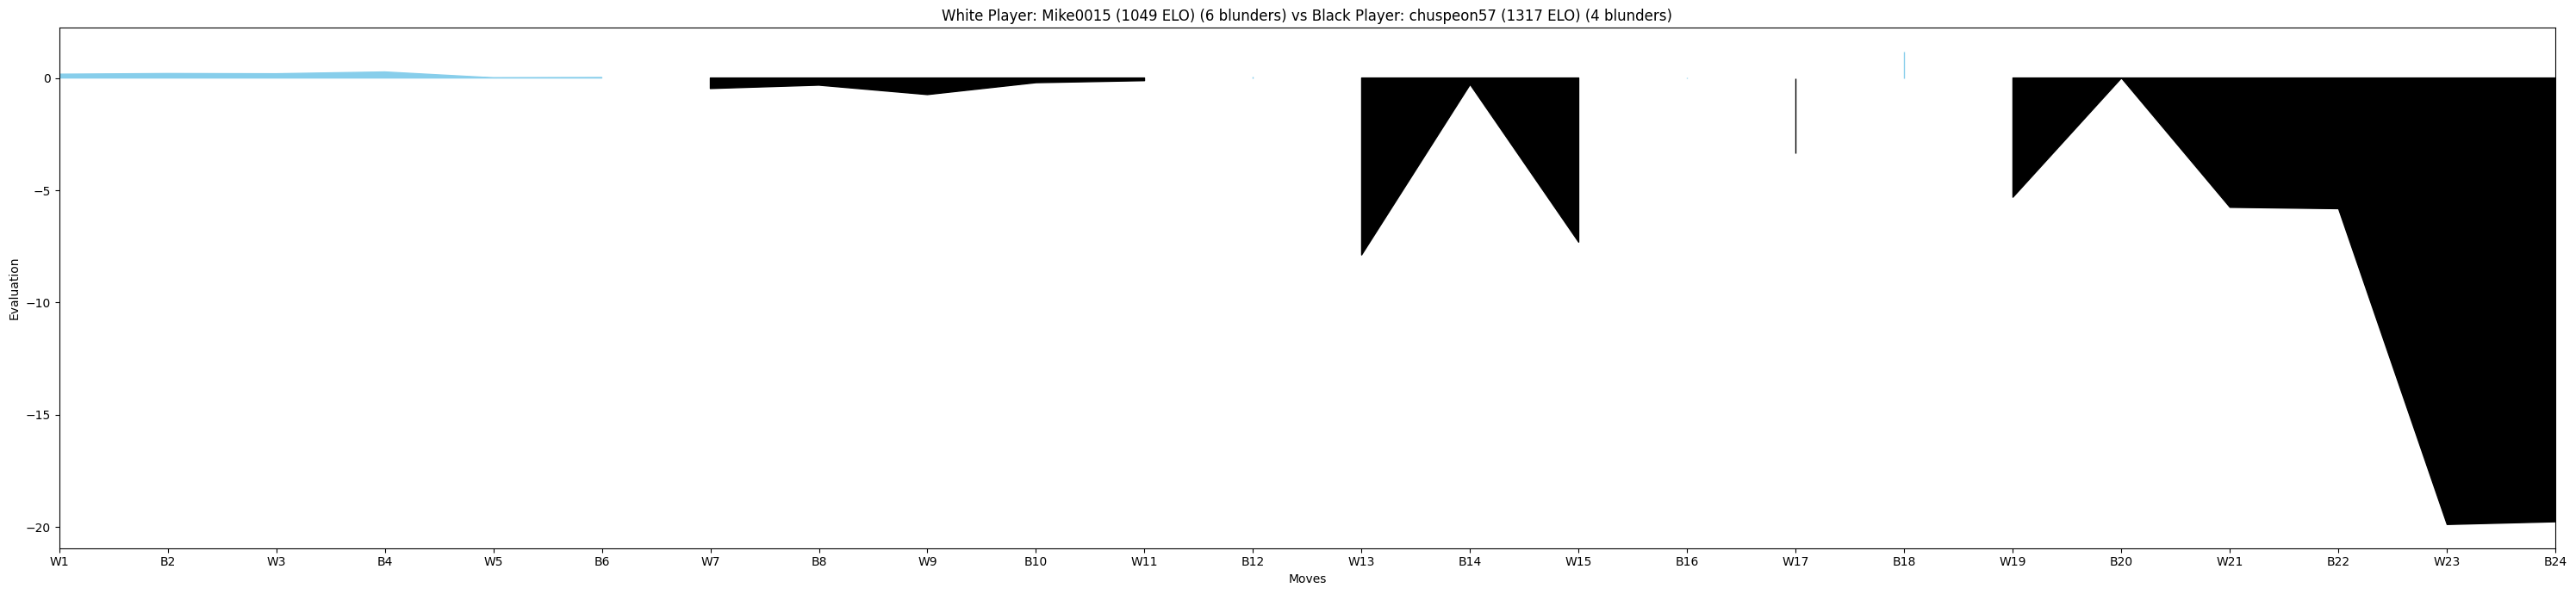

In [11]:
plot_eval_game_optimized(eval_games=eval_games)


In [12]:
# plot_eval_game(eval_games=eval_games) # garbo shitballz

### Group By
- Time control ~ (60, 120, 180, 600) etc...
- Elo-Brackets ~ ([1200, 1400], [1500, 1700], [2000-2200]) etc...

### Time Control Grouping

In [13]:
time_control_blunders_averages = eval_games \
    .groupBy("TimeControl") \
    .agg(mean("WhiteBlunders").alias("avg(WhiteBlunders)"), \
        mean("BlackBlunders").alias("avg(BlackBlunders)"), \
        mean("BlackElo").alias("avg(BlackElo)"), \
        mean("WhiteElo").alias("avg(WhiteElo)"), \
        count("TimeControl").alias("count(TimeControl)")) \
    .withColumn("avg(WhiteBlunders)", format_number("avg(WhiteBlunders)", 1)) \
    .withColumn("avg(BlackBlunders)", format_number("avg(BlackBlunders)", 1)) \
    .withColumn("avg(WhiteElo)", format_number("avg(WhiteElo)", 0)) \
    .withColumn("avg(BlackElo)", format_number("avg(BlackElo)", 0)) 

In [14]:
time_control_blunders_averages \
    .orderBy(col("avg(WhiteBlunders)").desc(), col("avg(BlackBlunders)").desc()) \
    .where(col("count(TimeControl)")>10000) \
    .limit(10) \
    .toPandas() \
    .head(10)

,TimeControl,avg(WhiteBlunders),avg(BlackBlunders),avg(BlackElo),avg(WhiteElo),count(TimeControl)
0,30+0,1.8,1.8,"1,799","1,807",22173
1,60+0,1.6,1.6,"1,794","1,795",93864
2,900+0,1.5,1.5,"1,669","1,670",16294
3,300+8,1.5,1.5,"1,656","1,654",16724
4,480+0,1.5,1.5,"1,740","1,743",10837
5,600+0,1.4,1.5,"1,727","1,727",39437
6,180+0,1.4,1.5,"1,764","1,766",87090
7,300+0,1.4,1.5,"1,635","1,634",106613
8,300+5,1.4,1.5,"1,714","1,715",10221
9,120+0,1.4,1.4,"1,639","1,645",12654


### Elo Brackets Grouping

Start off by Creating a new spark daraframe column called "EloBracket" which we will later use to group and aggregrate by. When grouping the players by elo brackets we want to use a range that makes sense such that there are not 1 bracket that contains 80% of the playerbase and ones that only contain a small fraction. E.g We want evenly distributed amount of players in each bracket (as far as that is possible).

/tmp/ipykernel_522466/1011671360.py:5: UserWarning:                             

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(elo_list, kde=True, color ='green', bins=20)


<Axes: ylabel='Density'>

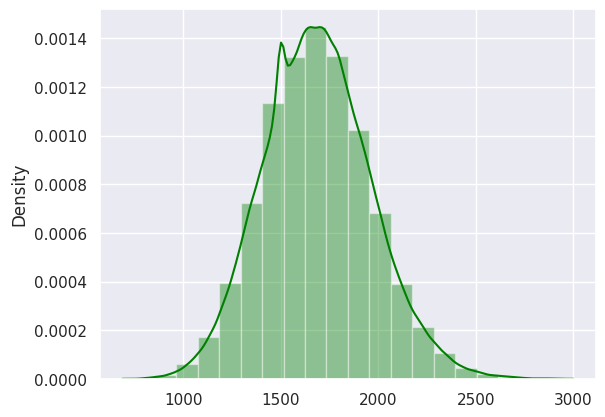

In [15]:
# Start by getting all the elo column values in the dataframe.
elo_list = eval_games.select(collect_list("WhiteElo")).first()[0]
sns.set_theme(style="ticks")
sns.set_style('darkgrid')
sns.distplot(elo_list, kde=True, color ='green', bins=20)

"EloBracket" column should be of type String and contain values in format: "0-1200", "1200-1600", "1600-2000", "2000-3000"

In [16]:
eval_games = eval_games.withColumn("EloBracket", \
                         when((0 < eval_games.WhiteElo) & (eval_games.WhiteElo < 1500), lit("<1500")) \
                        .when((1500 <= eval_games.WhiteElo) & (eval_games.WhiteElo <= 1750), lit("1500-1750")) \
                        .when((1750 < eval_games.WhiteElo) & (eval_games.WhiteElo <= 2000), lit("1751-2000")) \
                        .otherwise(lit(">2000")))

In [17]:
eval_games.show()

+--------------------+--------------+--------------+-------+--------+--------+--------------------+-----------+------------+--------------------+--------------------+-------------------+-------------+-------------+----------+
|               Event|         White|         Black| Result|WhiteElo|BlackElo|             Opening|TimeControl| Termination|               Moves|                Eval|       UTCTimestamp|WhiteBlunders|BlackBlunders|EloBracket|
+--------------------+--------------+--------------+-------+--------+--------+--------------------+-----------+------------+--------------------+--------------------+-------------------+-------------+-------------+----------+
|Rated Classical game|     AxStalker|        hazuki|    0-1|    1738|    2061|Russian Game: Thr...|     600+10|      Normal|['e4',  'e5',  'N...|[0.28, 0.3, 0.23,...|2016-05-07 23:08:16|            1|            0| 1500-1750|
|Rated Classical game|   zeppelin102|     Ragafayon|    1-0|    1670|    1593|     English Defen

### ELO and Blunders

In [18]:
elo_bracket_white_blunders_averages = eval_games \
    .groupBy("EloBracket") \
    .agg(mean("WhiteBlunders"), count("EloBracket")) \
    .withColumn("avg(WhiteBlunders)", format_number("avg(WhiteBlunders)", 1))

elo_bracket_black_blunders_averages = eval_games \
    .groupBy("EloBracket") \
    .agg(mean("BlackBlunders"), count("EloBracket")) \
    .withColumn("avg(BlackBlunders)", format_number("avg(BlackBlunders)", 1))

In [19]:
elo_bracket_white_blunders_averages.orderBy(col("avg(WhiteBlunders)").desc()).limit(10).toPandas().head()

,EloBracket,avg(WhiteBlunders),count(EloBracket)
0,<1500,1.8,161959
1,1500-1750,1.5,233325
2,1751-2000,1.3,178523
3,>2000,1.1,82612


In [20]:
elo_bracket_black_blunders_averages.orderBy(col("avg(BlackBlunders)").desc()).limit(10).toPandas().head()

,EloBracket,avg(BlackBlunders),count(EloBracket)
0,<1500,1.6,161959
1,1500-1750,1.5,233325
2,1751-2000,1.4,178523
3,>2000,1.3,82612


## Joining two tables to test optimization 

In [21]:
games_eval = df.join(eval_games, \
                [df.White == eval_games.White, \
                df.UTCTimestamp == eval_games.UTCTimestamp ]\
                ,"outer" ) 
                

In [22]:
games_eval.show()

+--------------------+---------+----------------+-------+--------+--------+--------------------+-----------+------------+--------------------+------+-------------------+-----+-----+-----+------+--------+--------+-------+-----------+-----------+-----+----+------------+-------------+-------------+----------+
|               Event|    White|           Black| Result|WhiteElo|BlackElo|             Opening|TimeControl| Termination|               Moves|  Eval|       UTCTimestamp|Event|White|Black|Result|WhiteElo|BlackElo|Opening|TimeControl|Termination|Moves|Eval|UTCTimestamp|WhiteBlunders|BlackBlunders|EloBracket|
+--------------------+---------+----------------+-------+--------+--------+--------------------+-----------+------------+--------------------+------+-------------------+-----+-----+-----+------+--------+--------+-------+-----------+-----------+-----+----+------------+-------------+-------------+----------+
|   Rated Bullet game| -ArtanS-|     khomamchess|    0-1|    1821|    1895| 

#### With hash-broadcast

In [23]:
#Enable broadcast Join and 
#Set Threshold limit of size in bytes of a DataFrame to broadcast
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 104857600)

#Disable broadcast Join
# spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [24]:
# Perform broadast join
from pyspark.sql.functions import broadcast, col

games_eval= df.join(
  broadcast(eval_games),
  ["White", "UTCTimestamp"],
  "outer"
).show()

+---------+-------------------+--------------------+----------------+-------+--------+--------+--------------------+-----------+------------+--------------------+------+-----+-----+------+--------+--------+-------+-----------+-----------+-----+----+-------------+-------------+----------+
|    White|       UTCTimestamp|               Event|           Black| Result|WhiteElo|BlackElo|             Opening|TimeControl| Termination|               Moves|  Eval|Event|Black|Result|WhiteElo|BlackElo|Opening|TimeControl|Termination|Moves|Eval|WhiteBlunders|BlackBlunders|EloBracket|
+---------+-------------------+--------------------+----------------+-------+--------+--------+--------------------+-----------+------------+--------------------+------+-----+-----+------+--------+--------+-------+-----------+-----------+-----+----+-------------+-------------+----------+
| -ArtanS-|2015-05-14 13:23:54|   Rated Bullet game|     khomamchess|    0-1|    1821|    1895|        Queen's Pawn|       60+0|     